In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
from collections import OrderedDict

from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

# OP simulator configuration
from voting_mechanism_design.legacy.op_simulator import Simulation as OPSimulation
from voting_mechanism_design.legacy.op_simulator import Round as OPRound
from voting_mechanism_design.legacy.op_simulator import Voter as OPVoter
from voting_mechanism_design.legacy.op_simulator import Project as OPProject

import itertools
import numpy as np
import choix
import math

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed

warnings.simplefilter(action='ignore', category=UserWarning)

In [27]:
def run_single_quorum_threshold_simulation(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        # configuration specific to quorum+threshold voting method
        quorum=5,
        scoring_fn='mean',
        min_vote_amt=1,
        max_vote_amt=16,
        max_funding=100,
        random_seed=1234
    ):
    round = OPRound(max_funding)
    round.min_project_vote = min_vote_amt
    round.max_project_vote = max_vote_amt
    rng = np.random.default_rng(random_seed)

    # create voters
    voters = []
    for ii in range(n_badgeholders):
        assert badgeholder_laziness_vec[ii] >= 0
        v = OPVoter(
            voter_id = ii,
            op_available=max_funding, # ignore the willingness_to_spend param, which was also done in Carl's simulations
            laziness=badgeholder_laziness_vec[ii],
            expertise=badgeholder_expertise_vec[ii],
        )
        voters.append(v)
    round.add_voters(voters)

    # add projects
    projects = []
    for ii in range(n_projects):
        p = OPProject(
            project_id=ii,
            rating=project_impact_vec[ii],
            owner_id=None,  # No COI modeling here
        )
        projects.append(p)
    round.add_projects(projects)

    ##  Voting Simulation
    ######################
    num_projects = round.num_projects
    for voter in round.voters:
        ballot_size = int((1 - voter.laziness_factor) * num_projects)

        # NOTE: this is updated to use the newer method of simulating
        # voter ranking of projects that is more directly comparable to 
        # the expertise encoding in the pairwise definition
        true_project_impact_vec = np.array([project.rating for project in round.projects])
        personal_ratings_ix = np.argsort(true_project_impact_vec)  # this is perfect rating
        p_shuffle_vec = np.zeros(len(personal_ratings_ix))
        for ii in range(len(personal_ratings_ix)):
            p_shuffle_vec[ii] = (1-voter.expertise_factor)      # currently, not dependent on the "true impact" of a project, but can be in the future
        # find which indices we should shuffle
        ix_to_shuffle = []
        for ii in range(len(p_shuffle_vec)):
            rv = rng.uniform(0,1)
            if rv < p_shuffle_vec[ii]:
                ix_to_shuffle.append(ii)
        # shuffle the indices that need to be
        personal_ratings_ix[ix_to_shuffle] = rng.permutation(personal_ratings_ix[ix_to_shuffle])
        sorted_project_indices = np.argsort(-personal_ratings_ix)

        print('>'*10)
        print(true_project_impact_vec)
        print(personal_ratings_ix)
        print(sorted_project_indices)
        
        for idx, project_idx in enumerate(sorted_project_indices):
            project = round.projects[project_idx]
            if idx >= ballot_size:
                amount = None
            else:
                if voter.laziness_factor > 0:
                    max_vote_per_project = (voter.balance_op * voter.laziness_factor) / np.sqrt(ballot_size - idx)
                else:
                    max_vote_per_project = voter.balance_op / np.sqrt(ballot_size - idx)
                if max_vote_per_project < min_vote_amt:
                    amount = None
                else:
                    lb = int(min_vote_amt)
                    ub = int(min(max_vote_amt, max_vote_per_project))

                    # CARL approach
                    # if lb >= ub:
                    #     amount = lb
                    # else:
                    #     # amount = rng.randint(lb, ub)
                    #     amount = rng.uniform(lb, ub)

                    # K2 approach - testing out how to reduce the variance in alignment
                    amount = max(lb, ub)
            voter.cast_vote(project, amount)
            print(idx, project_idx, project.project_id, amount)
        print('<'*10)
    ######################
    raise Exception("Test")

    projectid2score = round.calculate_scores(
        scoring_fn, 
        quorum
    )
    projectid2score = OrderedDict(projectid2score)
    ranks = np.argsort(np.asarray(list(projectid2score.values())))
    projectid2rank = {ii:ranks[ii] for ii in range(len(ranks))}
    
    return projectid2score, projectid2rank

def run_single_pairwise_simulation(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        random_seed=1234
    ):
    # create badgeholders
    badgeholder_list = []
    for ii in range(n_badgeholders):
        badgeholder_id = ii
        expertise = badgeholder_expertise_vec[ii]
        laziness = badgeholder_laziness_vec[ii]
        
        coi_project_ids = []
        engaging_in_coi = False
        agent = PairwiseBadgeholder(
            badgeholder_id=badgeholder_id,
            voting_style='skewed_towards_impact',
            voting_style_kwargs={'use_impact_delta':False},
            expertise=expertise,
            laziness=laziness,
            coi_projects=coi_project_ids,
            engaging_in_coi=engaging_in_coi,
        )
        badgeholder_list.append(agent)
    badgeholders = PairwiseBadgeholderPopulation()
    badgeholders.add_badgeholders(badgeholder_list)

    # create projects
    projects = []
    for ii in range(n_projects):
        project_id = ii
        project_impact = project_impact_vec[ii]
        project = Project(
            project_id=project_id,
            true_impact=project_impact,  
            owner_id=None,  # used for COI modeling
        )
        projects.append(project)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # this is a no-op currently, but can change in the future
    fund_distribution_model = PairwiseBinary()

    # create and run a simulation
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )

    # voters can vote on all projects, but an individual badgeholder can decide to ignore
    # some, based on the badgeholder configuration
    voting_view_ix = list(itertools.combinations(range(project_population.num_projects), 2))  # we need a list since we use this twice
    voting_view = []
    for ix1, ix2 in voting_view_ix:
        voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
    simulation_obj.run(cast_votes_kwargs={'view': voting_view})

    # store the project impact differences
    # this is only for diagnostics/post-hoc analysis
    impact_diff_vec = []
    for ix1, ix2 in voting_view_ix:
        p1 = project_population.get_project(ix1)
        p2 = project_population.get_project(ix2)
        impact_diff_vec.append(p1.true_impact - p2.true_impact)

    # make a matrix of all the pairwise voting possibilities
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_list = simulation_obj.projects.projects
    N = len(project_list)
    project_vote_matrix = np.zeros((N, N))
    project2ix = {p:ix for ix, p in enumerate(project_list)}
    vote_data_list = []

    # put the votes into the format needed by the choix package
    for v in all_votes:
        ix1 = project2ix[v.project1]
        ix2 = project2ix[v.project2]
        project_vote_matrix[ix1, ix2] += v.val1
        project_vote_matrix[ix2, ix1] += v.val2

        if v.val1 > v.val2:
            vote_data_list.append((ix1, ix2))
        elif v.val2 > v.val1:
            vote_data_list.append((ix2, ix1))
        else:
            # TODO: not sure if there is a tie, is that even possible??
            print('In Tie scenario!')
            pass

    # estimate parameters of bradley terry model - TODO: update to MCMC estimation
    try:
        params = choix.ilsr_pairwise(N, vote_data_list)  
    except Exception as e:
        print(f'Failed to estimate global rankings: {e}, adding some regularization!')
        params = choix.ilsr_pairwise(N, vote_data_list, alpha=0.01)
    # create rank order of project ids
    project_ix_worst_to_best_inferred = np.argsort(params)
    project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

    # # compare the inferred ranks to the actual ranks
    # actual_project_impacts = np.array([p.true_impact for p in project_list])
    # # rank them
    # project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
    # project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

    # return actual_project_impacts, project_ix_worst_to_best_inferred
    return params, project_ix_worst_to_best_inferred, impact_diff_vec

def run_single_simulation(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        quorum=5,
        scoring_fn='mean',
        min_vote_amt=1,
        max_vote_amt=16,
        max_funding=100,
        random_seed=1234
    ):
    qt_project_scores, qt_project_ranks = run_single_quorum_threshold_simulation(
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        # configuration specific to quorum+threshold voting method
        quorum=quorum,
        scoring_fn=scoring_fn,
        min_vote_amt=min_vote_amt,
        max_vote_amt=max_vote_amt,
        max_funding=max_funding,
        random_seed=random_seed
    )
    raise Exception("Test")

    # NOTE: this is a simple version which excludes
    # COI information.  We can build up the simulation to add this
    pairwise_project_scores, pairwise_project_ranks, impact_diff_vec = run_single_pairwise_simulation(
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        random_seed=random_seed
    )

    # the results to return, but others may contain useful diagnostics as well!
    pairwise_inferred_rankings = pairwise_project_ranks
    # qt_inferred_rankings = np.asarray(list(qt_project_ranks.values()))
    qt_inferred_rankings = []
    for ii in range(n_projects):
        qt_inferred_rankings.append(qt_project_ranks[ii])
    qt_inferred_rankings = np.asarray(qt_inferred_rankings)
    true_project_rankings = np.argsort(project_impact_vec)
    
    # compute rank correlation as an initial measure of how aligned 
    tau_pairwise = stats.kendalltau(true_project_rankings, pairwise_inferred_rankings)
    tau_qt = stats.kendalltau(true_project_rankings, qt_inferred_rankings)

    return {
        'rankings': {
            'pairwise': pairwise_inferred_rankings,
            'qt': qt_inferred_rankings,
            'true': true_project_rankings
        },
        'metrics': {
            # index-0 is the actual statistic, index-1 is a p-value or something
            'pairwise': tau_pairwise[0],
            'qt': tau_qt[0]
        }
    }

def run_n_simulations(
        n_sims,
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        quorum=5,
        scoring_fn='mean',
        min_vote_amt=1,
        max_vote_amt=16,
        max_funding=100,
        random_seed_start=1234,
        verbose=False,
    ):
    def run_simulation(ii):
        seed = random_seed_start + ii
        single_run_results = run_single_simulation(
            n_badgeholders=n_badgeholders,
            badgeholder_expertise_vec=badgeholder_expertise_vec,
            badgeholder_laziness_vec=badgeholder_laziness_vec,
            n_projects=n_projects,
            project_impact_vec=project_impact_vec,
            quorum=quorum,
            scoring_fn=scoring_fn,
            min_vote_amt=min_vote_amt,
            max_vote_amt=max_vote_amt,
            max_funding=max_funding,
            random_seed=seed
        )
        # return a dict so that we can create a dataframe of the results
        # for each configuration we test quickly
        return_dict = {
            'Pairwise': single_run_results['metrics']['pairwise'],
            'Q+T': single_run_results['metrics']['qt'],
            # 'pw_rank': single_run_results['rankings']['pairwise'],
            # 'qt_rank': single_run_results['rankings']['qt'],
            'n_badgeholders': n_badgeholders,
            'avg_expertise': np.mean(badgeholder_expertise_vec),
            'avg_laziness': np.mean(badgeholder_laziness_vec),
            'n_projects': n_projects,
            'quorum': quorum,
            'scoring_fn': scoring_fn,
            'min_vote_amt': min_vote_amt,
            'max_vote_amt': max_vote_amt,
            'max_funding': max_funding,
        }
        return return_dict
    
    # results = Parallel(n_jobs=-1)(delayed(run_simulation)(ii) for ii in tqdm(range(n_sims), disable=(not verbose)))
    results = []
    for ii in tqdm(range(n_sims), disable=(not verbose)):
        results.append(run_simulation(ii))

    return pd.DataFrame(results)


In [28]:
# setup simulation parameters
n_sims = 4

n_badgeholders_sweep = [25]
n_projects_sweep = [100]
# badgeholder_expertise_sweep = [0.0, 0.25, 0.5, 0.75, 1.0]
# badgeholder_laziness_sweep = [0.0, 0.5, 0.75]
badgeholder_expertise_sweep = [1.0]
badgeholder_laziness_sweep = [0.0, 0.5, 0.75]
# TODO: make this w/ itertools ...
experiment_cfgs = []
for n_badgeholders in n_badgeholders_sweep:
    for n_projects in n_projects_sweep:
        for badgeholder_expertise in badgeholder_expertise_sweep:
            for badgeholder_laziness in badgeholder_laziness_sweep:
                experiment_cfgs.append((n_badgeholders, n_projects, badgeholder_expertise, badgeholder_laziness))
# parameters that we can explore
quorum=5
scoring_fn='mean'
min_vote_amt=1
max_vote_amt=16
max_funding=100

all_results = []
for experiment_cfg in tqdm(experiment_cfgs):
    n_badgeholders=experiment_cfg[0]
    n_projects=experiment_cfg[1]

    badgeholder_expertise_vec=np.ones(n_badgeholders) * experiment_cfg[2]
    badgeholder_laziness_vec=np.ones(n_badgeholders) * experiment_cfg[3]

    random_seed_start=123
    project_impact_vec=np.linspace(0, 1, n_projects)  # enforce a strict ranking that we can compare against

    results_df = run_n_simulations(
        n_sims,
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        quorum=quorum,
        scoring_fn=scoring_fn,
        min_vote_amt=min_vote_amt,
        max_vote_amt=max_vote_amt,
        max_funding=max_funding,
        random_seed_start=random_seed_start,
        verbose=False
    )
    all_results.append(results_df)
all_results = pd.concat(all_results)

  0%|          | 0/3 [00:00<?, ?it/s]

>>>>>>>>>>
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888

Exception: Test

In [13]:
dff = pd.melt(
    all_results, 
    value_vars=['Pairwise', 'Q+T'], value_name='Rank Corr', var_name='Mechanism',
    id_vars=['n_badgeholders', 'avg_expertise', 'avg_laziness', 'n_projects', 'quorum']
)
dff['Hue'] = ''
for ii, row in dff.iterrows():
    out_str = '%s//%0.02f' % (row['Mechanism'], row['avg_laziness'],)
    dff.at[ii, 'Hue'] = out_str

In [14]:
dff

,n_badgeholders,avg_expertise,avg_laziness,n_projects,quorum,Mechanism,Rank Corr,Hue
0,25,0.5,0.00,100,5,Pairwise,0.974141,Pairwise//0.00
1,25,0.5,0.00,100,5,Pairwise,0.971313,Pairwise//0.00
2,25,0.5,0.00,100,5,Pairwise,0.970505,Pairwise//0.00
3,25,0.5,0.00,100,5,Pairwise,0.969293,Pairwise//0.00
4,25,0.5,0.50,100,5,Pairwise,0.962020,Pairwise//0.50
5,25,0.5,0.50,100,5,Pairwise,0.950303,Pairwise//0.50
6,25,0.5,0.50,100,5,Pairwise,0.955960,Pairwise//0.50
7,25,0.5,0.50,100,5,Pairwise,0.949091,Pairwise//0.50
8,25,0.5,0.75,100,5,Pairwise,0.925253,Pairwise//0.75
9,25,0.5,0.75,100,5,Pairwise,0.934141,Pairwise//0.75


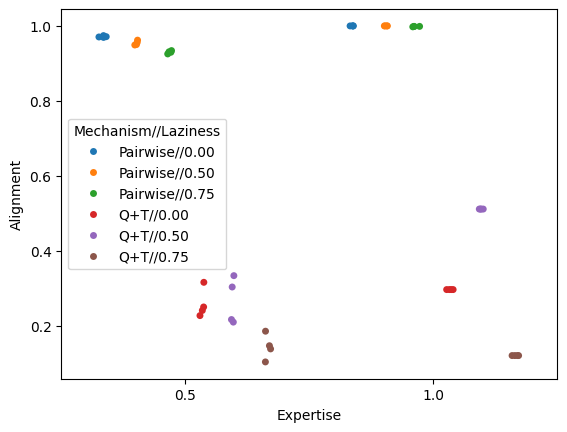

In [15]:
sns.stripplot(
    data=dff, x="avg_expertise", y="Rank Corr", hue="Hue",
    dodge=True, zorder=1, legend=True, palette="tab10"
)
plt.xlabel('Expertise')
plt.ylabel('Alignment')
plt.legend(title='Mechanism//Laziness')

In [16]:
# The reason why there is still misalignment is b/c even though the ranks are aligned
# having a score of 100 w/ integer voting is making it so that a lot of projects
# get the same vote, like a series of 1s or 2s, which is not enough to differentiate
# and I think this is why we are geting misalignment now.